In [1]:
# import packages
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import Quandl
plt.style.use('fivethirtyeight')

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.cross_validation  import train_test_split

Using Theano backend.


---

# *U.S. Treasury Bills:*
## Predicting 12-Month Rates, using 30 day windows of 3-Month and 6-Month Rates as input

---

### Data Wrangling

In [3]:
# set date range
start_date = "1982-01-04"
end_date = "2016-03-11"

In [4]:
# read in Fed Funds Rate, 3-Month, 6-Month, 12-Month Treasury Bill data from Quandl
three_month = Quandl.get("FRED/DGS3MO", trim_start=start_date, trim_end=end_date)
six_month = Quandl.get("FRED/DGS6MO", trim_start=start_date, trim_end=end_date)
twelve_month = Quandl.get("FRED/DGS1", trim_start=start_date, trim_end=end_date)

In [5]:
# reset indices 
three_month.reset_index(level=0, inplace=True)
six_month.reset_index(level=0, inplace=True)
twelve_month.reset_index(level=0, inplace=True)

In [6]:
# normalize data to heave mean = 0, std = 1
three_month['normal'] = (three_month['VALUE'] - three_month['VALUE'].mean(axis=0)) / three_month['VALUE'].std(axis=0, ddof=1)
six_month['normal'] = (six_month['VALUE'] - six_month['VALUE'].mean(axis=0)) / six_month['VALUE'].std(axis=0, ddof=1)
twelve_month['normal'] = (twelve_month['VALUE'] - twelve_month['VALUE'].mean(axis=0)) / twelve_month['VALUE'].std(axis=0, ddof=1)

In [7]:
# merge into single DataFrame
data = three_month.merge(six_month, on = 'DATE')
data = data.merge(twelve_month, on = 'DATE')

In [8]:
# rename columns
data.columns = ['date', '3_rate', '3_norm', '6_rate', '6_norm', '12_rate', '12_norm']

### Window 

In [9]:
index_count = 0

# create first entries of the sampling window
window_x = (data[['3_norm', '6_norm']].values[0:30]).reshape((1,60))
window_y = (data[['12_norm']].values[0:30]).reshape((1,30))

# iterate through the dataframe and append each successive sampling window
for i in xrange(30,8550,30):
    temp_x = (data[['3_norm', '6_norm']].values[i:i+30]).reshape((1,60))
    window_x = np.concatenate((window_x, temp_x))
    
    temp_y = (data[['12_norm']].values[i:i+30]).reshape((1,30))
    window_y = np.concatenate((window_y, temp_y)) 

    index_count += 1

### Train / Test Split

In [10]:
# split data in train/test with a test size of 0.30
x_train, x_test, y_train, y_test  = train_test_split(window_x, 
                                                     window_y, 
                                                     test_size=0.30, 
                                                     random_state=42)

### Neural Network

In [11]:
# build sequential neural network model with:
# 150 hidden units
# 0.2 dropout regularizer
# tanh activation function
# mean squared error loss function
# stochastic gradient descent optimizer

model = Sequential()
model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('tanh'))
model.add(Dense(output_dim=30))

model.compile(loss='mean_squared_error', optimizer='sgd')

In [12]:
# fit model to data
history = model.fit(x_train, y_train, 
                    verbose=0, 
                    nb_epoch=2000, 
                    batch_size=500,
                    validation_data=(x_test, y_test))

### Error

In [13]:
score = model.evaluate(x_train, y_train, batch_size=2000)
print 'Training error %f' % (score)
print ''

score = model.evaluate(x_test, y_test, batch_size=2000)
print 'Test error %f' % (score)

199/199 [==============================] - 0s
Training error 0.010002

86/86 [==============================] - 0s
Test error 0.010376


### Loss

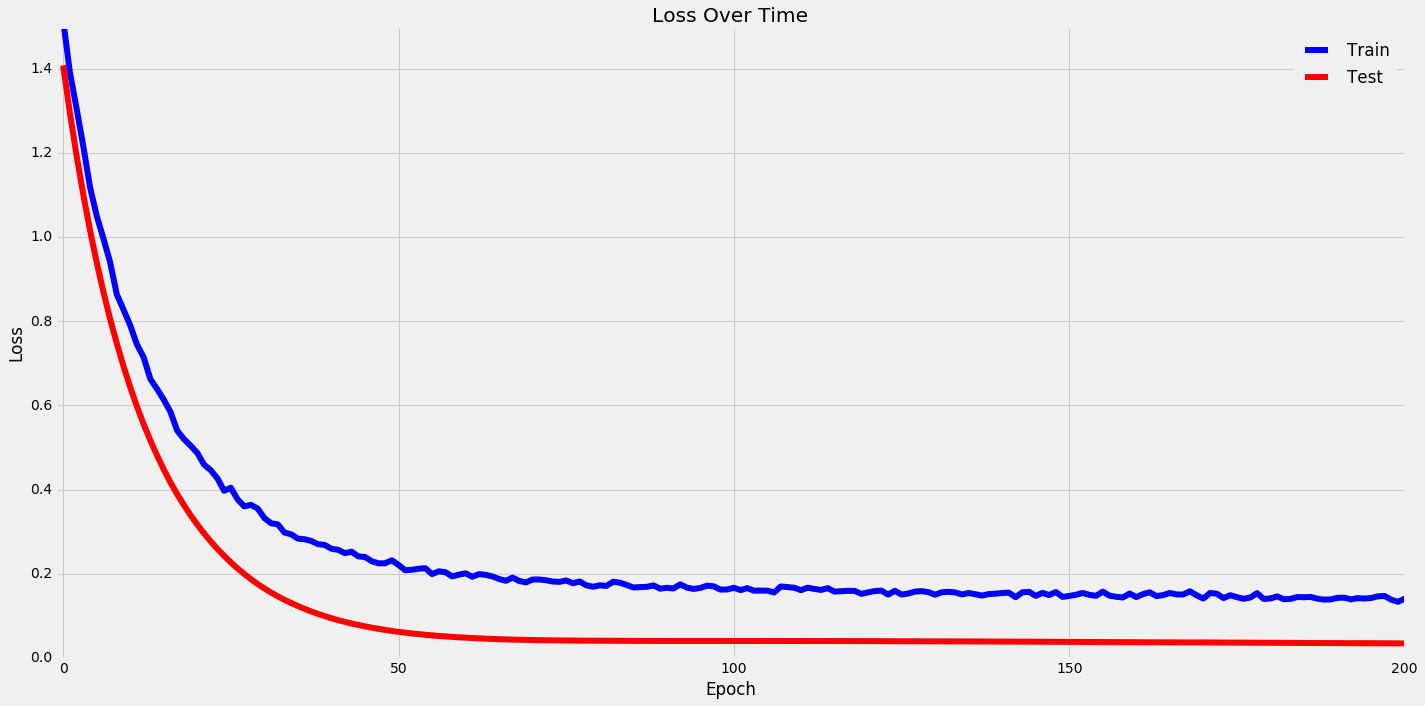

In [14]:
fig = plt.figure(figsize=(20,10))
plt.subplot(111)
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1.5])
plt.xlim([-1,200])
    
train = plt.plot(history.epoch, history.history['loss'], color='blue', label='Train', linewidth=6)
val = plt.plot(history.epoch, history.history['val_loss'], color='red', label='Test', linewidth=6)
plt.legend(loc='upper right')

plt.tight_layout()

### Value Plots

In [15]:
# predict based on test features
y_pred_test = model.predict(x_test)

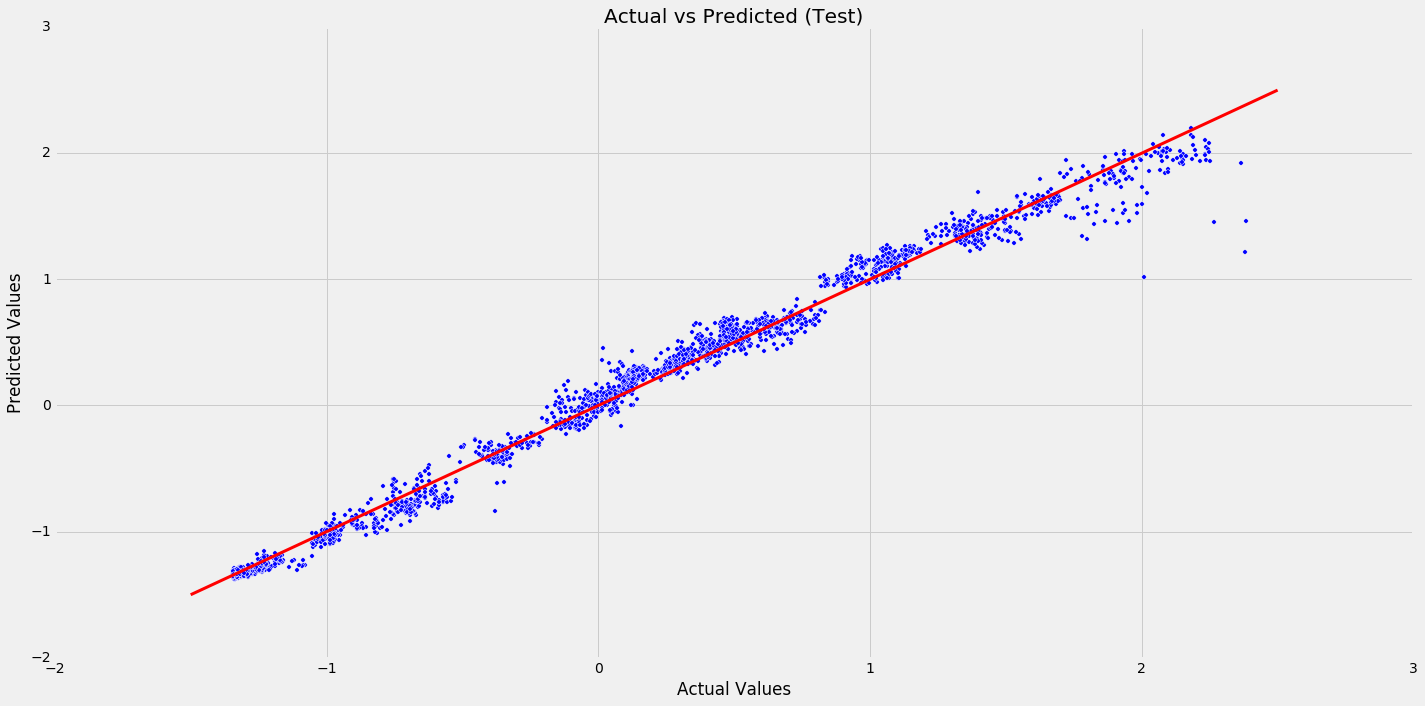

In [16]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.subplot(111)
plt.scatter(y_test , y_pred_test, color='blue', edgecolors='white')
plt.plot([-1.5, 2.5], [-1.5, 2.5], linewidth=3, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Test)')

plt.tight_layout()

In [17]:
# plot predicted vs actual
actual = y_test.reshape(2580,1)
prediction = y_pred_test.reshape(2580,1)

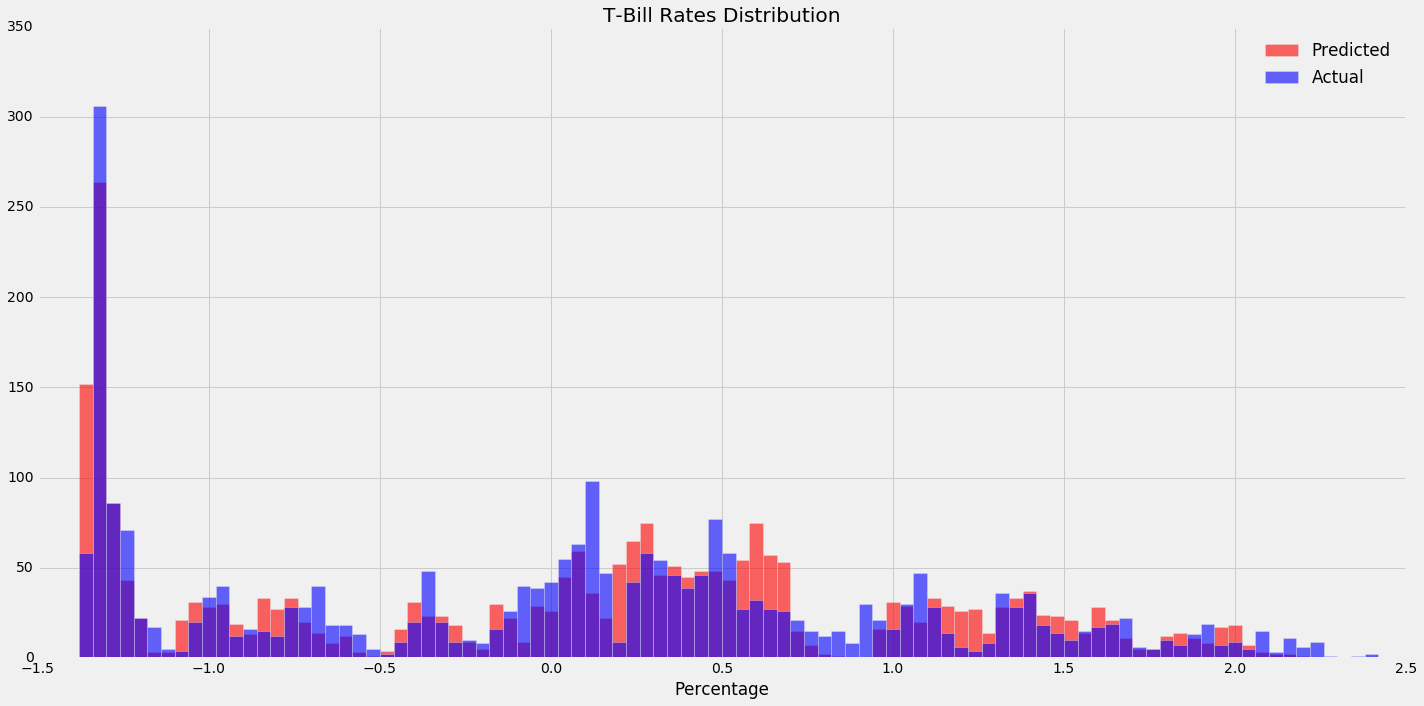

In [18]:
bins = 100
range = [-1.5, 2.5]
alpha = 0.6
fig = plt.figure(figsize=(20,10))

plt.subplot(111)

plt.title("T-Bill Rates Distribution")
plt.xlabel('Percentage')

plt.hist(prediction, color='red', bins=bins, alpha=alpha, range=range, label='Predicted')
plt.hist(actual, color='blue', bins=bins, alpha=alpha, range=range, label='Actual')

plt.legend(loc='upper right')

plt.tight_layout()

---

# *UK Eurodollar Rate:*
## Using US model to predict 6-month UK Rates, using 30 day windows of 1-month and 3-month UK Rates as input

---

### Data Wrangling

In [19]:
# read in 1-Month, 3-Month, 6-Month UK Eurodollar rates
uk_one_month = pd.read_csv('DED1.csv')
uk_three_month = pd.read_csv('DED3.csv')
uk_six_month = pd.read_csv('DED6.csv')

In [20]:
# cut data to have same date range as US data
uk_one_month = uk_one_month[2870:]
uk_three_month = uk_three_month[2870:]
uk_six_month = uk_six_month[2870:]

In [21]:
# merge into single DataFrame
uk_data = uk_one_month.merge(uk_three_month, on = 'DATE')
uk_data = uk_data.merge(uk_six_month, on = 'DATE')

In [22]:
# rename columns
uk_data.columns = ['date', '1_rate', '3_rate', '6_rate']

In [23]:
# remove blank rows
uk_data = uk_data[uk_data['1_rate'] != '.']
uk_data = uk_data[uk_data['3_rate'] != '.']
uk_data = uk_data[uk_data['6_rate'] != '.']

In [24]:
# convert to float
uk_data['1_rate'] = uk_data['1_rate'].astype(np.float32)
uk_data['3_rate'] = uk_data['3_rate'].astype(np.float32)
uk_data['6_rate'] = uk_data['6_rate'].astype(np.float32)

In [25]:
# normalize data to heave mean = 0, std = 1
uk_data['1_norm'] = (uk_data['1_rate'] - uk_data['1_rate'].mean(axis=0)) / uk_data['1_rate'].std(axis=0, ddof=1)
uk_data['3_norm'] = (uk_data['3_rate'] - uk_data['3_rate'].mean(axis=0)) / uk_data['3_rate'].std(axis=0, ddof=1)
uk_data['6_norm'] = (uk_data['6_rate'] - uk_data['6_rate'].mean(axis=0)) / uk_data['6_rate'].std(axis=0, ddof=1)

In [26]:
# cut by a number divisible by 30
uk_data = uk_data[:8730]

### Window

In [27]:
index_count = 0

# create first entries of the sampling window
uk_window_x = (uk_data[['1_norm', '3_norm']].values[0:30]).reshape((1,60))
uk_window_y = (uk_data[['6_norm']].values[0:30]).reshape((1,30))

# iterate through the dataframe and append each successive sampling window
for i in xrange(30,8730,30):
    uk_temp_x = (uk_data[['1_norm', '3_norm']].values[i:i+30]).reshape((1,60))
    uk_window_x = np.concatenate((uk_window_x, uk_temp_x))
    
    uk_temp_y = (uk_data[['6_norm']].values[i:i+30]).reshape((1,30))
    uk_window_y = np.concatenate((uk_window_y, uk_temp_y)) 

    index_count += 1

### Error

In [28]:
score = model.evaluate(uk_window_x, uk_window_y, batch_size=2000)
print 'Error %f' % (score)
print ''

291/291 [==============================] - 0s
Error 0.012914



### Value Plots

In [29]:
# predict based on test features
y_pred_test_uk = model.predict(uk_window_x)

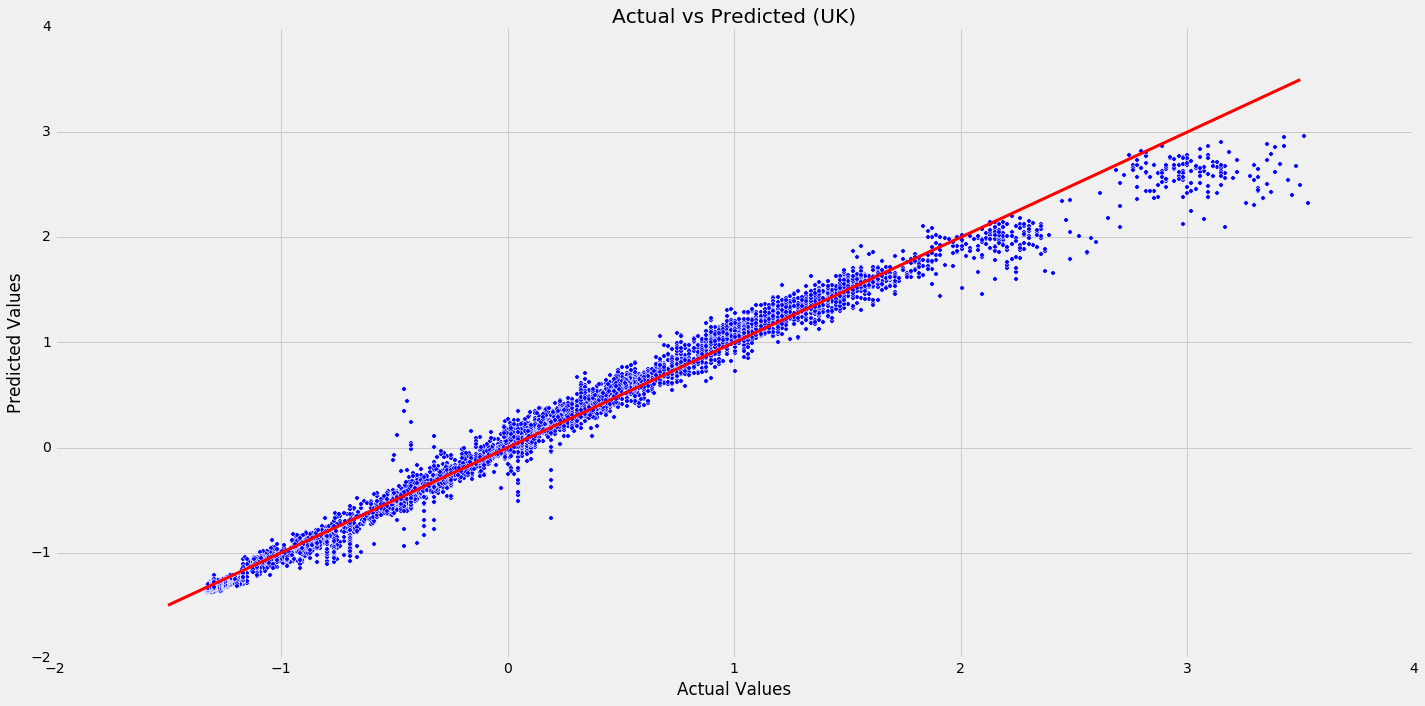

In [30]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.subplot(111)
plt.scatter(uk_window_y , y_pred_test_uk, color='blue', edgecolors='white')
plt.plot([-1.5, 3.5], [-1.5, 3.5], linewidth=3, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (UK)')

plt.tight_layout()

In [31]:
# plot predicted vs actual
actual = uk_window_y.reshape(8730,1)
prediction = y_pred_test_uk.reshape(8730,1)

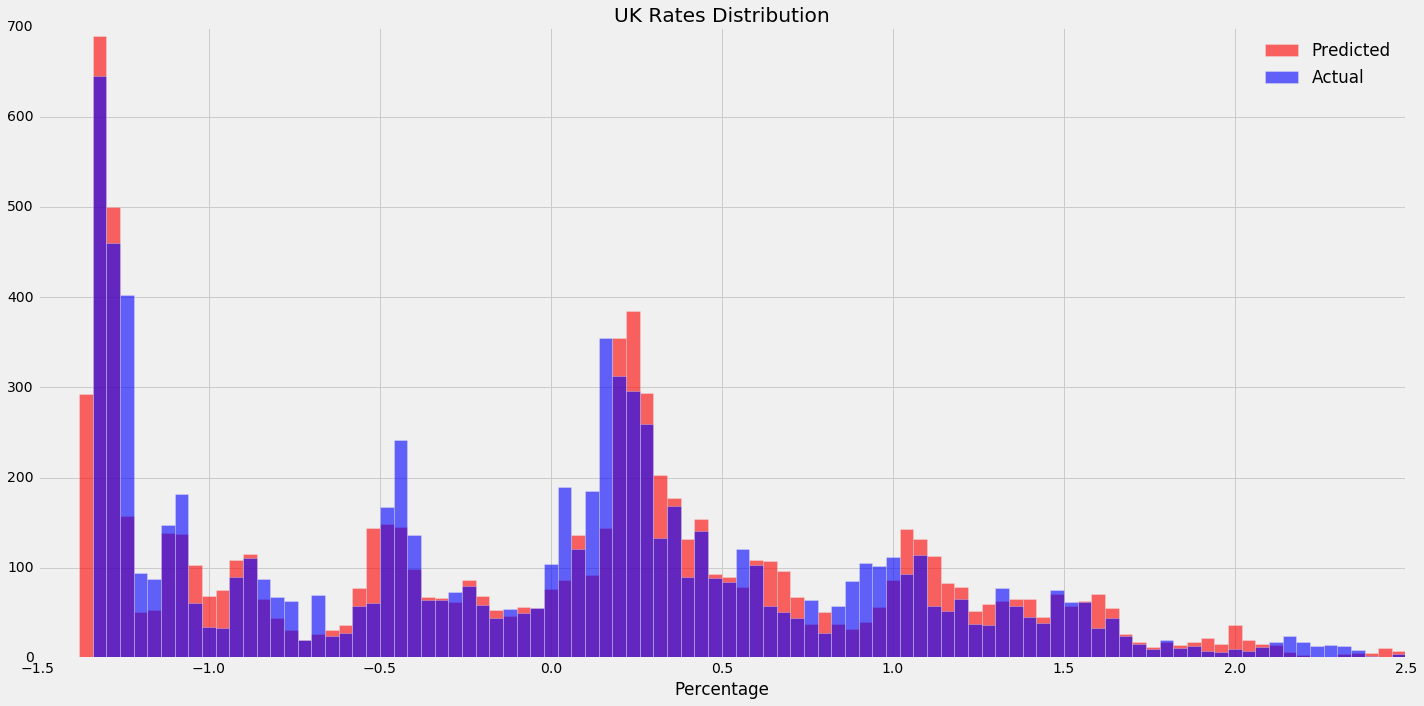

In [32]:
bins = 100
range = [-1.5, 2.5]
alpha = 0.6
fig = plt.figure(figsize=(20,10))

plt.subplot(111)

plt.title("UK Rates Distribution")
plt.xlabel('Percentage')

plt.hist(prediction, color='red', bins=bins, alpha=alpha, range=range, label='Predicted')
plt.hist(actual, color='blue', bins=bins, alpha=alpha, range=range, label='Actual')

plt.legend(loc='upper right')

plt.tight_layout()